In [1]:
import os
import fiona
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
import geopandas as geo
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



viridis = cm.get_cmap('viridis', 6)

## Data Informations
All data shared from 
[CapitalBikeShare](https://www.capitalbikeshare.com/system-data)

## Tasks to make
- Identify the variables that most impact hourly ridership
- Develop a model to predict hourly bikeshare demand in the region based on historical ridership and weather data for next year
- Get a total of members and casual clients
- Explore how many clients use in normal work/study hour 6~9 12~14 18~20
- Get the most stations used
- Get the most bikes used by the time used


In [2]:
dataframe_stations_raw = pd.read_json('https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json', orient='values')

In [3]:
dataframe_stations = dataframe_stations_raw.copy()
dataframe_stations = pd.DataFrame(dataframe_stations.data.stations).set_index('station_id')
print('dataframe_stations Length: ',len(dataframe_stations))
dataframe_stations.head()

dataframe_stations Length:  650


,short_name,station_type,lat,eightd_station_services,has_kiosk,electric_bike_surcharge_waiver,lon,rental_uris,eightd_has_key_dispenser,region_id,capacity,rental_methods,name,external_id,legacy_id
station_id,,,,,,,,,,,,,,,
1,31000,classic,38.858971,[],True,False,-77.053230,"{'ios': 'https://dc.lft.to/lastmile_qr_scan', ...",False,41,15,"[KEY, CREDITCARD]",Eads St & 15th St S,082469cc-1f3f-11e7-bf6b-3863bb334450,1
2,31001,classic,38.857250,[],True,False,-77.053320,"{'ios': 'https://dc.lft.to/lastmile_qr_scan', ...",False,41,11,"[KEY, CREDITCARD]",18th St & S Eads St,08246b69-1f3f-11e7-bf6b-3863bb334450,2
3,31002,classic,38.856425,[],True,False,-77.049232,"{'ios': 'https://dc.lft.to/lastmile_qr_scan', ...",False,41,17,"[KEY, CREDITCARD]",Crystal Dr & 20th St S,08246c35-1f3f-11e7-bf6b-3863bb334450,3
4,31003,classic,38.861056,[],True,False,-77.049417,"{'ios': 'https://dc.lft.to/lastmile_qr_scan', ...",False,41,16,"[KEY, CREDITCARD]",Crystal Dr & 15th St S,08246cd5-1f3f-11e7-bf6b-3863bb334450,4
5,31004,classic,38.857866,[],True,False,-77.059490,"{'ios': 'https://dc.lft.to/lastmile_qr_scan', ...",False,41,12,"[KEY, CREDITCARD]",Aurora Hills Cmty Ctr / 18th St & S Hayes St,08246d68-1f3f-11e7-bf6b-3863bb334450,5


In [4]:
dataframe_tripdata_raw = pd.read_csv('2016Q1-capitalbikeshare-tripdata.csv')
print('dataframe_tripdata_raw Length: ',len(dataframe_tripdata_raw))
dataframe_tripdata_raw.head()

dataframe_tripdata_raw Length:  552399


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


In [5]:
dataframe_tripdata = dataframe_tripdata_raw.copy()
print('dataframe_tripdata Length: ',len(dataframe_tripdata))
dataframe_tripdata.head()

dataframe_tripdata Length:  552399


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type


### Total of clients by the type

In [6]:
dataframe_membertype = dataframe_tripdata.groupby('Member type')['Duration'].count().reset_index()
dataframe_membertype.rename(columns={'Duration':'Total'}, inplace=True)
dataframe_membertype.head()

,Member type,Total
0,Casual,84967
1,Member,467432


### DataFrame Casual Clients

In [7]:
dataframe_casualclients = dataframe_tripdata[dataframe_tripdata['Member type'] == 'Casual']
print('dataframe_casualclients Length: ',len(dataframe_casualclients))
dataframe_casualclients.head()

dataframe_casualclients Length:  84967


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
5,859,2016-01-01 00:16:18,2016-01-01 00:30:37,31041,Prince St & Union St,31048,King St Metro South,W01122,Casual
11,278,2016-01-01 00:27:26,2016-01-01 00:32:05,31231,14th & D St NW / Ronald Reagan Building,31262,11th & F St NW,W00922,Casual
23,2018,2016-01-01 00:32:51,2016-01-01 01:06:30,31246,M St & Pennsylvania Ave NW,31513,Rhode Island Ave & V St NE,W22120,Casual
35,1285,2016-01-01 00:39:53,2016-01-01 01:01:18,31632,15th & F St NE,31632,15th & F St NE,W21072,Casual
39,1187,2016-01-01 00:43:49,2016-01-01 01:03:36,31258,Lincoln Memorial,31077,Iwo Jima Memorial/N Meade & 14th St N,W20562,Casual


### DataFrame Member Clients

In [8]:
dataframe_memberclients = dataframe_tripdata[dataframe_tripdata['Member type'] == 'Member']
print('dataframe_memberclients Length: ',len(dataframe_memberclients))
dataframe_memberclients.head()

dataframe_memberclients Length:  467432


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


### DataFrame Total Casual Clients By Stations

In [9]:
dataframe_casual_by_station = dataframe_casualclients.groupby('Start station number')['Member type'].count().reset_index()
dataframe_casual_by_station.rename(columns={'Start station number':'station_id','Member type':'total'}, inplace=True)
print('dataframe_casual_by_station Length: ',len(dataframe_casual_by_station))
dataframe_casual_by_station.head()

dataframe_casual_by_station Length:  355


,station_id,total
0,31000,73
1,31001,75
2,31002,225
3,31003,199
4,31004,16


### DataFrame Member Clients By Stations

In [10]:
dataframe_member_by_station = dataframe_memberclients.groupby('Start station number')['Member type'].count().reset_index()
dataframe_member_by_station.rename(columns={'Start station number':'station_id','Member type':'total'}, inplace=True)
print('dataframe_member_by_station Length: ',len(dataframe_member_by_station))
dataframe_member_by_station.head()

dataframe_member_by_station Length:  370


,station_id,total
0,31000,226
1,31001,294
2,31002,695
3,31003,713
4,31004,657


# Day Users
## Morning Clients
6am ~ 9am

In [11]:
dataframe_morning_clients = dataframe_tripdata.copy()
dataframe_morning_clients['Start date'] = pd.to_datetime(dataframe_morning_clients['Start date'])
dataframe_morning_clients.set_index('Start date',inplace=True)
dataframe_morning_clients = dataframe_morning_clients.between_time('06:00:00','09:00:00')
print('Total Morning Clients: ',len(dataframe_morning_clients))
dataframe_morning_clients.head()

Total Morning Clients:  95095


,Duration,End date,Start station number,Start station,End station number,End station,Bike number,Member type
Start date,,,,,,,,
2016-01-01 06:10:51,468,2016-01-01 06:18:39,31600,5th & K St NW,31200,Massachusetts Ave & Dupont Circle NW,W20027,Member
2016-01-01 06:19:47,271,2016-01-01 06:24:18,31047,Braddock Rd Metro,31048,King St Metro South,W00503,Member
2016-01-01 06:28:01,344,2016-01-01 06:33:46,31117,15th & Euclid St NW,31201,15th & P St NW,W21372,Member
2016-01-01 06:31:06,1132,2016-01-01 06:49:58,31026,Washington Blvd & 10th St N,31076,Shirlington Transit Center / S Quincy & Randol...,W21086,Casual
2016-01-01 06:31:13,1406,2016-01-01 06:54:40,31117,15th & Euclid St NW,31108,4th & M St SW,W01030,Member


In [12]:
dataframe_morning_clients_total_by_type = dataframe_morning_clients.groupby('Member type')['Duration'].count().reset_index()
dataframe_morning_clients_total_by_type.rename(columns={'Duration':'Total'}, inplace=True)
dataframe_morning_clients_total_by_type

,Member type,Total
0,Casual,3273
1,Member,91822


## Lunch Clients 
12am ~ 14pm

In [13]:
dataframe_lunch_clients = dataframe_tripdata.copy()
dataframe_lunch_clients['Start date'] = pd.to_datetime(dataframe_lunch_clients['Start date'])
dataframe_lunch_clients.set_index('Start date',inplace=True)
dataframe_lunch_clients = dataframe_lunch_clients.between_time('12:00:00','14:00:00')
print('Total LunchTime Clients: ',len(dataframe_lunch_clients))
dataframe_lunch_clients.head()

Total LunchTime Clients:  61398


,Duration,End date,Start station number,Start station,End station number,End station,Bike number,Member type
Start date,,,,,,,,
2016-01-01 12:00:07,1358,2016-01-01 12:22:45,31242,18th St & Pennsylvania Ave NW,31248,Smithsonian-National Mall / Jefferson Dr & 12t...,W20537,Casual
2016-01-01 12:00:11,1334,2016-01-01 12:22:26,31242,18th St & Pennsylvania Ave NW,31248,Smithsonian-National Mall / Jefferson Dr & 12t...,W20312,Casual
2016-01-01 12:00:13,234,2016-01-01 12:04:08,31619,Lincoln Park / 13th & East Capitol St NE,31612,D St & Maryland Ave NE,W20463,Member
2016-01-01 12:00:20,8377,2016-01-01 14:19:58,31618,4th & East Capitol St NE,31639,2nd & G St NE,W00172,Member
2016-01-01 12:00:21,392,2016-01-01 12:06:53,31245,7th & R St NW / Shaw Library,31232,7th & F St NW / National Portrait Gallery,W21769,Member


In [14]:
dataframe_lunch_clients_total_by_type = dataframe_lunch_clients.groupby('Member type')['Duration'].count().reset_index()
dataframe_lunch_clients_total_by_type.rename(columns={'Duration':'Total'}, inplace=True)
dataframe_lunch_clients_total_by_type

,Member type,Total
0,Casual,15889
1,Member,45509


## Go Night Clients
18pm ~ 20pm

In [15]:
dataframe_night_clients = dataframe_tripdata.copy()
dataframe_night_clients['Start date'] = pd.to_datetime(dataframe_night_clients['Start date'])
dataframe_night_clients.set_index('Start date',inplace=True)
dataframe_night_clients = dataframe_night_clients.between_time('18:00:00','20:00:00')
print('Total Night Clients: ',len(dataframe_night_clients))
dataframe_night_clients.head()

Total Night Clients:  85083


,Duration,End date,Start station number,Start station,End station number,End station,Bike number,Member type
Start date,,,,,,,,
2016-01-01 18:01:54,229,2016-01-01 18:05:44,31109,7th & T St NW,31506,1st & Rhode Island Ave NW,W00272,Member
2016-01-01 18:02:04,384,2016-01-01 18:08:29,31202,14th & R St NW,31116,California St & Florida Ave NW,W20429,Member
2016-01-01 18:02:26,1161,2016-01-01 18:21:48,31103,16th & Harvard St NW,31276,15th & L St NW,W00129,Casual
2016-01-01 18:02:29,516,2016-01-01 18:11:06,31229,New Hampshire Ave & T St NW,31509,New Jersey Ave & R St NW,W00153,Member
2016-01-01 18:02:32,1162,2016-01-01 18:21:54,31103,16th & Harvard St NW,31276,15th & L St NW,W22180,Casual


In [16]:
dataframe_night_clients_total_by_type = dataframe_night_clients.groupby('Member type')['Duration'].count().reset_index()
dataframe_night_clients_total_by_type.rename(columns={'Duration':'Total'}, inplace=True)
dataframe_night_clients_total_by_type

,Member type,Total
0,Casual,8878
1,Member,76205


# Most used stations
top 10 stations

In [17]:
dataframe_sort_stations = dataframe_tripdata.groupby('Start station number')['Duration'].count().reset_index()
dataframe_sort_stations.rename(columns={'Start station number':'station_id', 'Duration':'Total'}, inplace=True)
dataframe_sort_stations.sort_values(by=['Total'],axis=0,ascending=False,inplace=True)
print('Top 10 Stations')
dataframe_sort_stations[:10]

Top 10 Stations


,station_id,Total
274,31623,13120
123,31200,9560
180,31258,9388
169,31247,8138
163,31241,7479
124,31201,7401
101,31101,6568
151,31229,6491
264,31613,5649
136,31214,5514


# Most used bikes
top 10 of bikes

In [18]:
dataframe_sort_bikes = dataframe_tripdata.groupby('Bike number')['Duration'].count().reset_index()
dataframe_sort_bikes.rename(columns={'Bike number':'bike_id', 'Duration':'Total'}, inplace=True)
dataframe_sort_bikes.sort_values(by=['Total'],axis=0,ascending=False,inplace=True)
print('Top 10 Bikes most used')
dataframe_sort_bikes[:10]

Top 10 Bikes most used


,bike_id,Total
3017,W21797,345
3400,W22227,337
2845,W21609,337
38,W00045,332
1694,W20384,328
1931,W20632,324
294,W00346,322
1561,W20242,322
2489,W21239,320
2440,W21186,320


## Time of use bike
Trying to find the total of used bikes
looks like it's in seconds
>Probably I'll convert to hours or days 

In [19]:
dataframe_time_used = dataframe_tripdata.groupby('Bike number')['Duration'].sum().reset_index()
dataframe_time_used.sort_values(by=['Duration'],axis=0,ascending=False,inplace=True)
dataframe_time_used

,Bike number,Duration
1273,W01410,386143
1436,W20098,384611
2503,W21253,368121
364,W00420,367593
2338,W21068,366573
...,...,...
2039,W20745,463
1492,W20162,344
820,W00919,262
283,W00335,251


# Time for plot the data
Distribution Subscriber Type

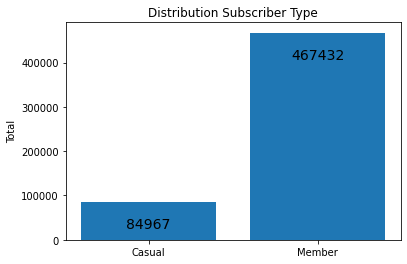

In [20]:
plt.bar(x=dataframe_membertype["Member type"], height=dataframe_membertype["Total"])
for index,data in enumerate(dataframe_membertype["Total"]):
    plt.text(x=index, y=data-50000, s=f"{data}" , fontsize=14, horizontalalignment='center', verticalalignment='center')

plt.ylabel("Total")
plt.title("Distribution Subscriber Type")
plt.show()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


## Import maps with GeoPandas
Search for Virginia USA